In [1]:
# # to install the package
# !pip install mlxtend

# # just in case you are running on Google Colab, you may run into a problem later on if you do not upgrade the package
# %pip install mlxtend --upgrade

In [2]:
# store the item sets as lists of strings in a list
transactions = [
    ["beer", "wine", "cheese"],
    ["beer", "potato chips"],
    ["eggs", "flower", "butter", "cheese"],
    ["eggs", "flower", "butter", "beer", "potato chips"],
    ["wine", "cheese"],
    ["potato chips"],
    ["eggs", "flower", "butter", "wine", "cheese"],
    ["eggs", "flower", "butter", "beer", "potato chips"],
    ["wine", "beer"],
    ["beer", "potato chips"],
    ["butter", "eggs"],
    ["beer", "potato chips"],
    ["flower", "eggs"],
    ["beer", "potato chips"],
    ["eggs", "flower", "butter", "wine", "cheese"],
    ["beer", "wine", "potato chips", "cheese"],
    ["wine", "cheese"],
    ["beer", "potato chips"],
    ["wine", "cheese"],
    ["beer", "potato chips"],
]

不可能將 FP Growth 算法直接適用於交易列表。您首先必須使用類似於 One-Hot Encoder 的編碼器對其進行編碼。 TransactionEncoder 由 mlxtend 包提供，您可以使用以下代碼生成編碼數據幀：

In [3]:
# it is necessary for mlxtend to reorganise the data
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

# instantiate a transaction encoder
my_transactionencoder = TransactionEncoder()

# fit the transaction encoder using the list of transaction tuples
my_transactionencoder.fit(transactions)

# transform the list of transaction tuples into an array of encoded transactions
encoded_transactions = my_transactionencoder.transform(transactions)

# convert the array of encoded transactions into a dataframe
encoded_transactions_df = pd.DataFrame(encoded_transactions, columns=my_transactionencoder.columns_)
encoded_transactions_df

,beer,butter,cheese,eggs,flower,potato chips,wine
0,True,False,True,False,False,False,True
1,True,False,False,False,False,True,False
2,False,True,True,True,True,False,False
3,True,True,False,True,True,True,False
4,False,False,True,False,False,False,True
5,False,False,False,False,False,True,False
6,False,True,True,True,True,False,True
7,True,True,False,True,True,True,False
8,True,False,False,False,False,False,True
9,True,False,False,False,False,True,False


In [4]:
#下一步是計算頻繁項集。您可以使用 mlxtend 中的 fpgrowth 函數，如下所示：

# our min support is 7, but it has to be expressed as a percentage for mlxtend
min_support = 7/len(transactions) 

# compute the frequent itemsets using fpgriowth from mlxtend
from mlxtend.frequent_patterns.fpgrowth import fpgrowth
frequent_itemsets = fpgrowth(encoded_transactions_df, min_support=min_support, use_colnames = True)

# print the frequent itemsets
frequent_itemsets

,support,itemsets
0,0.55,(beer)
1,0.40,(wine)
2,0.40,(cheese)
3,0.50,(potato chips)
4,0.35,(eggs)
5,0.35,"(wine, cheese)"
6,0.45,"(potato chips, beer)"


## 解讀 The rules 規則
Firstly, we can conclude that there are two product combinations, and both associations are bidirectional. People who buy cheese, also buy wine and people who buy wine also buy cheese. Separately, we see that people who buy beer also buy potato chips and vice versa.

首先，我們可以得出結論，有兩種產品組合，兩種關聯都是雙向的。買奶酪的人也買酒，買酒的人也買奶酪。另外，我們看到購買啤酒的人也購買薯片，反之亦然。


## The metrics of the rules 規則的度量
A second thing that is interesting to look at is the metrics of the rules. Together, they tell us something about the reliability of the rules. The following three metrics are important to look at:

第二件有趣的事情是規則的指標。它們一起告訴我們有關規則可靠性的一些信息。以下三個指標很重要：
- The support tells us the number of times, or percentage, that the products co-occur 支持告訴我們產品同時出現的次數或百分比
- The confidence tells us the number of times that a rule occurs. This can be stated differently as the conditional probability of the right-hand side given the left-hand side 置信度告訴我們規則出現的次數。這可以不同地表示為給定左側的右側的條件概率
- The lift gives us the strength of association Lift給了我們聯想的力量

In [5]:
#作為最後一步，我們需要使用 association_rules 函數將那些頻繁項集轉換為關聯規則。這可以使用以下代碼完成：
# Compute the association rules based on the frequent itemsets
from mlxtend.frequent_patterns import association_rules

# compute and print the association rules
rule = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(wine),(cheese),0.40,0.40,0.35,0.875000,2.187500,0.190,4.80,0.904762
1,(cheese),(wine),0.40,0.40,0.35,0.875000,2.187500,0.190,4.80,0.904762
2,(potato chips),(beer),0.50,0.55,0.45,0.900000,1.636364,0.175,4.50,0.777778
3,(beer),(potato chips),0.55,0.50,0.45,0.818182,1.636364,0.175,2.75,0.864198


In [6]:
# ### Filter
# rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
# rules["consequents_len"] = rules["consequents"].apply(lambda x: len(x))
# rules["antecedents"] = rules["antecedents"].apply(lambda x: ','.join(list(x))).astype("unicode")    
# rules["consequents"] = rules["consequents"].apply(lambda x: ','.join(list(x))).astype("unicode")    
# FPGrowth = rules[ (rules['antecedent_len'] >= 2) &                            # At least 2 antecedents
#                   (rules['consequents_len'] >= 2) &                            # At least 2 antecedents
#                   (rules['confidence'] > 0.75) &                              # A confidence > 0.75
#                   (rules['lift'] > 1.0) ].reset_index(drop=True)               # A lift score > 1.0
# FPGrowth = FPGrowth[0:1000]
# FPGrowth

## matplotlib3
https://matplotlib.org/3.5.0/gallery/misc/packed_bubbles.html

In [7]:
import pandas as pd

bubbledata = rule[['antecedents', 'consequents', 'support']]
df = pd.DataFrame(bubbledata)
df['antecedents_str'] = df['antecedents'].apply(lambda x: '(' + '&'.join(map(str, x)) + ')')
df['consequents_str'] = df['consequents'].apply(lambda x: '(' + '&'.join(map(str, x)) + ')')
df['merged'] = df['antecedents_str'] + '\n' + df['consequents_str']
df = df.drop(['antecedents', 'consequents', 'antecedents_str', 'consequents_str'], axis=1)
df

,support,merged
0,0.35,(wine)\n(cheese)
1,0.35,(cheese)\n(wine)
2,0.45,(potato chips)\n(beer)
3,0.45,(beer)\n(potato chips)


C:\Users\cti110016\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


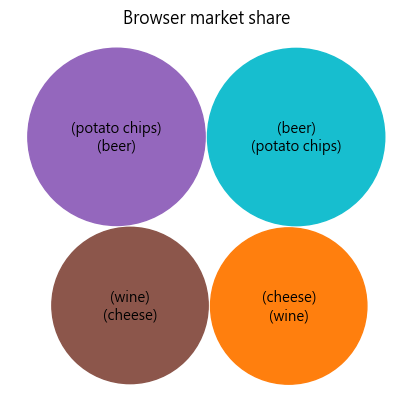

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
browser_market_share = df


class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]
        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels):
        bubble_colors = np.random.choice(list(mcolors.TABLEAU_COLORS.values()), size=len(self.bubbles))

        for i in range(len(self.bubbles)):
            circ = plt.Circle(self.bubbles[i, :2], self.bubbles[i, 2], color=bubble_colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')


bubble_chart = BubbleChart(area=browser_market_share['support'],
                           bubble_spacing=0.01)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(ax, browser_market_share['merged'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Browser market share')

plt.show()

In [9]:
#作為最後一步，我們需要使用 association_rules 函數將那些頻繁項集轉換為關聯規則。這可以使用以下代碼完成：
# Compute the association rules based on the frequent itemsets
from mlxtend.frequent_patterns import association_rules

# compute and print the association rules
rule = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(wine),(cheese),0.40,0.40,0.35,0.875000,2.187500,0.190,4.80,0.904762
1,(cheese),(wine),0.40,0.40,0.35,0.875000,2.187500,0.190,4.80,0.904762
2,(potato chips),(beer),0.50,0.55,0.45,0.900000,1.636364,0.175,4.50,0.777778
3,(beer),(potato chips),0.55,0.50,0.45,0.818182,1.636364,0.175,2.75,0.864198


## D3 Blocks - bubble chart 
https://github.com/d3blocks/d3blocks

中文內容顯示會有問題

In [10]:
import pandas as pd

bubbledata = rule[['antecedents', 'consequents', 'support']]
df = pd.DataFrame(bubbledata)

df['antecedents'] = df['antecedents'].apply(lambda x: '(' + '&'.join(map(str, x)) + ')')#.astype(str)
df['consequents'] = df['consequents'].apply(lambda x: '(' + '&'.join(map(str, x)) + ')')#.astype(str)
df['support'] = df['support'] * 100

df = df.rename(columns={'antecedents': 'source', 'consequents': 'target', 'support': 'weight'})
#df = df.drop(['antecedents_str', 'consequents_str'], axis=1)
df

from d3blocks import D3Blocks
d3 = D3Blocks()
d3.d3graph(df, filepath='d3graph.html')

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Set directed=True to see the markers!
C:\Users\cti110016\AppData\Local\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
[d3blocks] >INFO> Keep only edges with weight>0
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Converting adjacency matrix into source-target..
C:\Users\cti110016\AppData\Local\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_typ

In [11]:
from datetime import datetime,timedelta
yesterday = datetime.now() + timedelta(days = -1)
date = yesterday.strftime('%Y-%m-%d')
date2= datetime.now().strftime('%Y-%m-%d 01:00:00')


with open('index.html', 'w', encoding='utf8') as rw:
    
    NLPList = '<h2 style="text-align:center;background: #f00; color: #fff; margin: 0 4px; border-radius: 4px;">Test</h2>'
    rw.write(NLPList)

    time_news = '<div><h3 style="text-align:center;color:gray">Date From{} to {} </h2></div>'.format(date, date2)
    rw.write(time_news)

    rw.write('<div style="float:left;">')
    rw.write('<iframe src="d3graph.html" height="1280px" width="960px" ,="" frameborder="0"></iframe>')
    #<iframe src="https://erdogant.github.io\docs\d3blocks\d3graph_example1.html" height="800px" width="775px" ,="" frameborder="0"></iframe>
    rw.write('</div>')